In [91]:
import os
import zipfile
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files

In [92]:
uploaded = files.upload()
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("animals")

Dataset_dir = "animals/animal_dataset"

Categories = [c for c in os.listdir(Dataset_dir) if os.path.isdir(os.path.join(Dataset_dir, c))]
print("Categories found:", Categories)

Saving animal_dataset.zip to animal_dataset (10).zip
Categories found: ['panda', 'dog', 'cat']


In [93]:
IMG_SIZE = 32
NUM_IMAGES = 300

all_data = []
for category in Categories:
    path = os.path.join(Dataset_dir, category)
    class_index = Categories.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]

In [ ]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)  
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)
print("Total images processed:", len(features))

Total images processed: 300


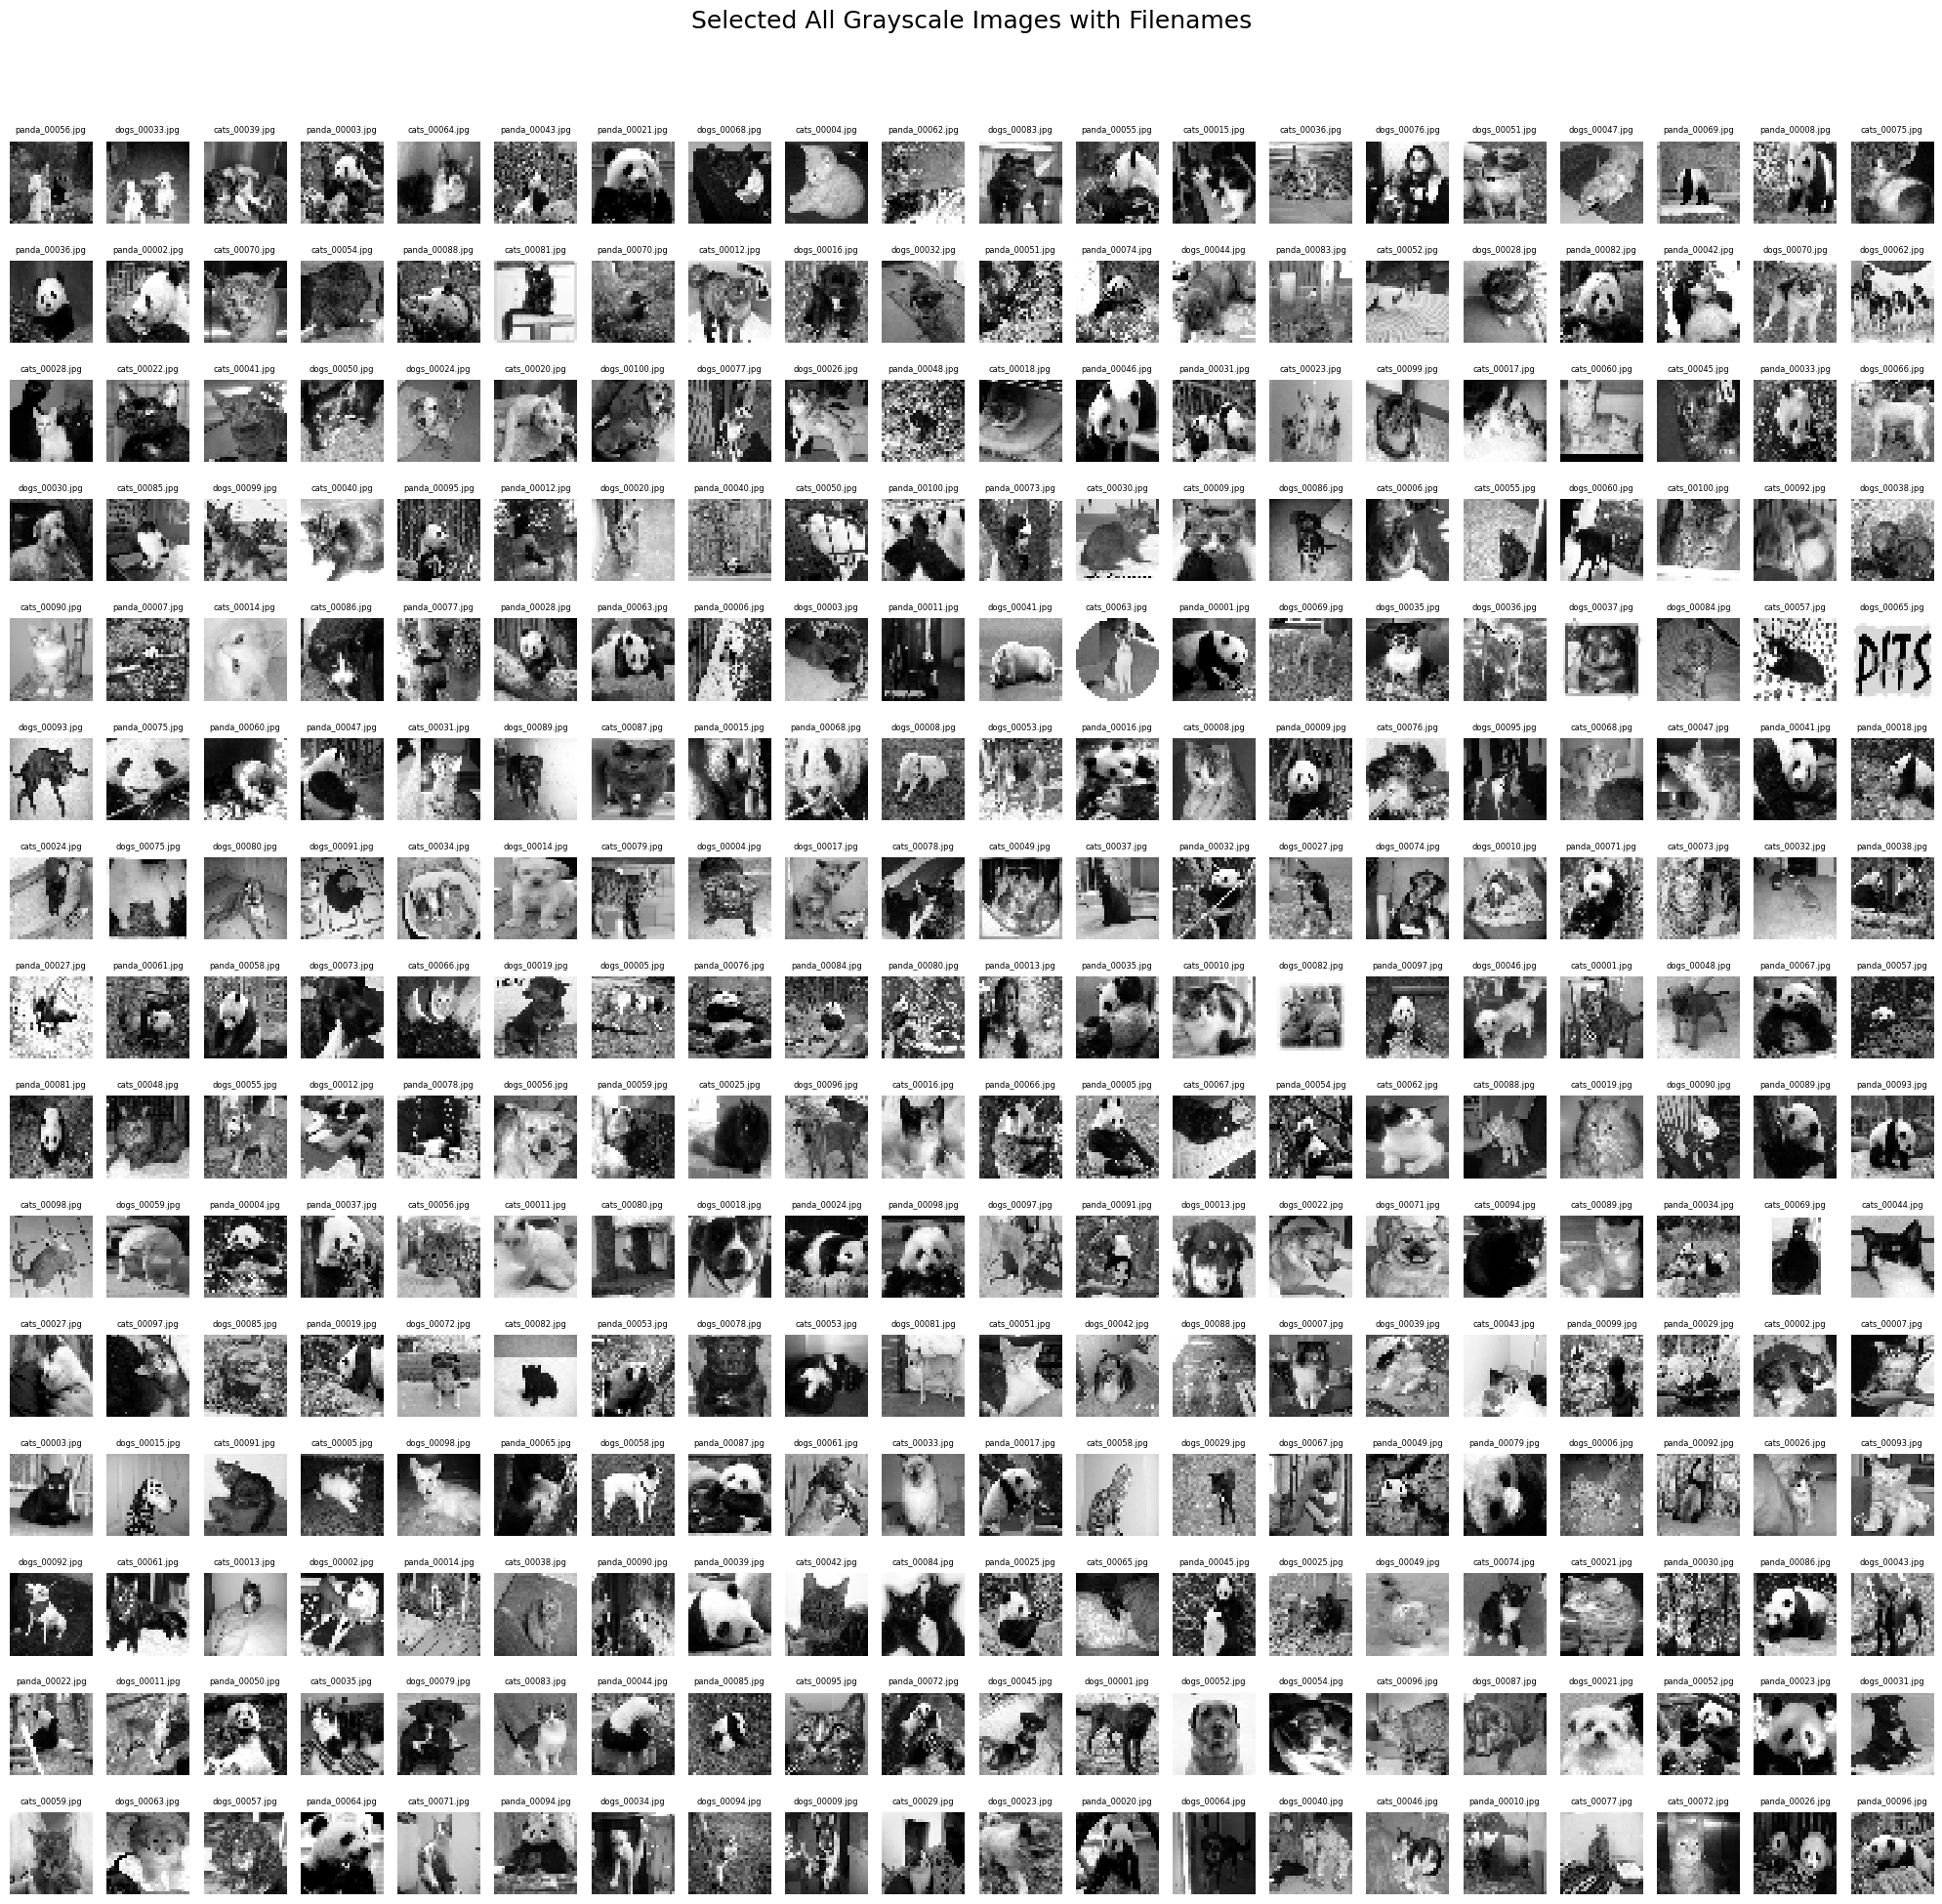

In [95]:
plt.figure(figsize=(20, 20))
for i in range(min(len(display_data), 300)):
    img, _, name = display_data[i]
    plt.subplot(15, 20, i + 1)
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(name[:100], fontsize=6)
    plt.axis('off')

plt.suptitle("Selected All Grayscale Images with Filenames", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



In [96]:
data = list(zip(features, labels))
random.shuffle(data)
fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]
remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])

for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))

Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


In [97]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

In [98]:
def knn_predict(X_train, y_train, x_test, k=3, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

In [99]:
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []
        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)
        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies

K_values = np.arange(1, 21)
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

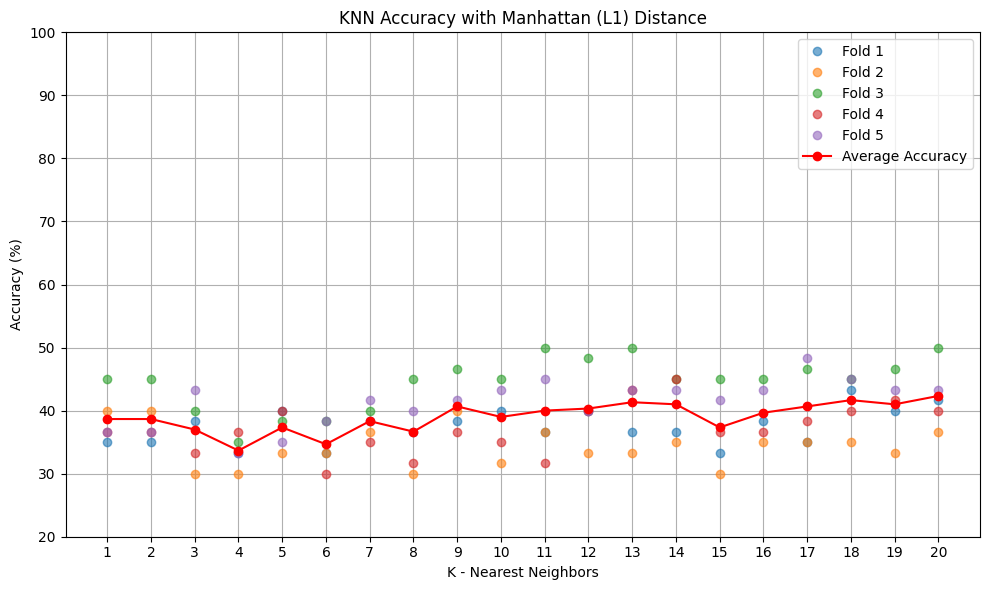

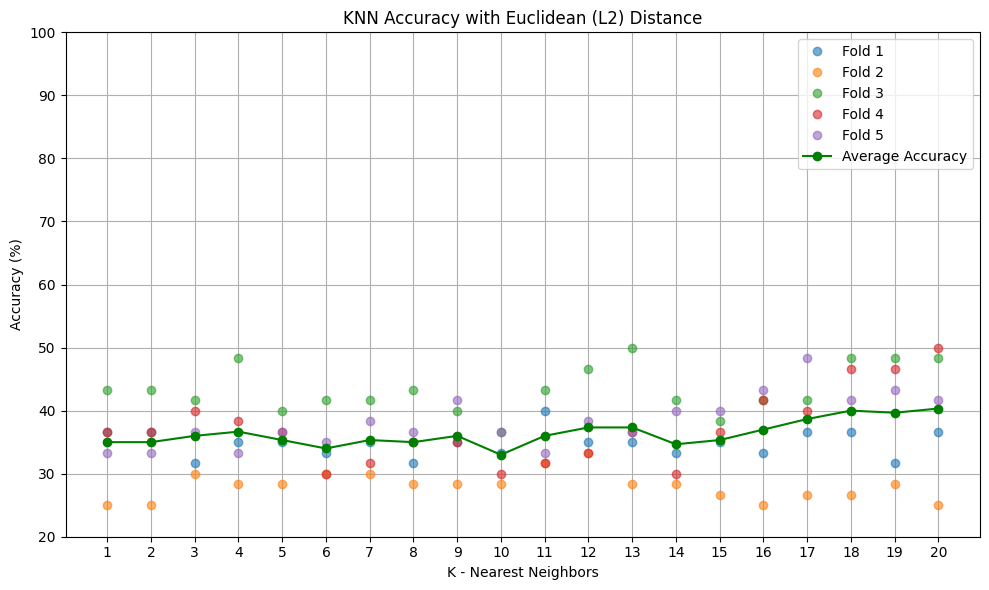

In [100]:
def plot_knn_accuracy(K, fold_accuracies, avg_accuracies, title, color):
    plt.figure(figsize=(10, 6))
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K, acc, 'o', label=f'Fold {i+1}', alpha=0.6)
    plt.plot(K, avg_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=1.5)
    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 21, 1))
    plt.ylim(20, 100)
    plt.tight_layout()
    plt.show()

plot_knn_accuracy(K_values, fold_acc_l1, avg_acc_l1, "KNN Accuracy with Manhattan (L1) Distance", color='red')
plot_knn_accuracy(K_values, fold_acc_l2, avg_acc_l2, "KNN Accuracy with Euclidean (L2) Distance", color='green')

In [101]:
print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")

Average Accuracy for Manhattan (L1) Distance:
K =  1 : 38.67%
K =  2 : 38.67%
K =  3 : 37.00%
K =  4 : 33.67%
K =  5 : 37.33%
K =  6 : 34.67%
K =  7 : 38.33%
K =  8 : 36.67%
K =  9 : 40.67%
K = 10 : 39.00%
K = 11 : 40.00%
K = 12 : 40.33%
K = 13 : 41.33%
K = 14 : 41.00%
K = 15 : 37.33%
K = 16 : 39.67%
K = 17 : 40.67%
K = 18 : 41.67%
K = 19 : 41.00%
K = 20 : 42.33%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 35.00%
K =  2 : 35.00%
K =  3 : 36.00%
K =  4 : 36.67%
K =  5 : 35.33%
K =  6 : 34.00%
K =  7 : 35.33%
K =  8 : 35.00%
K =  9 : 36.00%
K = 10 : 33.00%
K = 11 : 36.00%
K = 12 : 37.33%
K = 13 : 37.33%
K = 14 : 34.67%
K = 15 : 35.33%
K = 16 : 37.00%
K = 17 : 38.67%
K = 18 : 40.00%
K = 19 : 39.67%
K = 20 : 40.33%


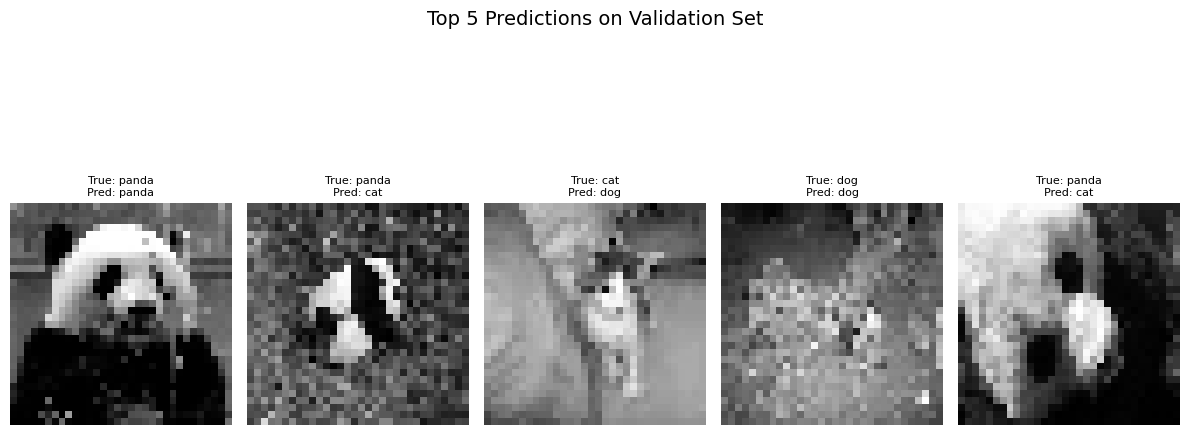

In [102]:
top5 = folds[0][:5]
training_set = [item for i, fold in enumerate(folds) if i != 0 for item in fold]

plt.figure(figsize=(12, 6))
for i, (img_flat, true_label) in enumerate(top5):
    pred_label = knn_predict(
        X_train=np.array([item[0] for item in training_set]),
        y_train=np.array([item[1] for item in training_set]),
        x_test=img_flat,
        k=3,
        distance_type='l2'
    )
    img = img_flat.reshape(IMG_SIZE, IMG_SIZE)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Categories[true_label]}\nPred: {Categories[pred_label]}", fontsize=8)
    plt.axis('off')
plt.suptitle("Top 5 Predictions on Validation Set", fontsize=14)
plt.tight_layout()
plt.show()